In [1]:
using Pkg;
Pkg.add("SparseArrays")
Pkg.add("Arpack")
Pkg.add("LinearAlgebra")
Pkg.add("Plots")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [52]:
using SparseArrays
using Arpack
using LinearAlgebra

# Create diagonal using individual arrays from grid. 
# Reshape first dimension diagonal from output into N dimensional grid using Ng values if needed
function kronSum(Ng::Array{Int64,1}, Grid::Array{Array{Float64}})
    dim = length(Ng)
    spd = Array{SparseMatrixCSC{Float64,Int64}}(undef,dim)
    spe = Array{SparseMatrixCSC{Float64,Int64}}(undef,dim)
    for ii=1:(dim)
        spd[ii] = spdiagm(0=>Grid[ii])
        spe[ii] = SparseMatrixCSC{Float64}(I, Ng[ii], Ng[ii])
    end
    for ii=2:dim
        spd[1] = kron(spd[1],spe[ii]) + kron(spe[1],spd[ii])
        #spe[1] = SparseMatrixCSC{Float64}(I, size(spd[1])[1], size(spd[1])[1])
    end
    return spd[1]
end

# 2D Stencil for k grid
function l2d(Ng::Array{Int64,1})
    dim = length(Ng)
    sp = SparseMatrixCSC{Float64}(I, Ng[1], Ng[1])
    E = sparse(2:Ng[1], 1:Ng[1]-1, 1, Ng[1], Ng[1])
    D = E+E' -2*sp;
    K = kron(D,sp) + kron(sp,D)
    return K
end

# Creates the spatial grid given maximum values and number of samples
function SpatialGrid(Ng::Array{Int64,1},GridMax::Array{Float64,1},GridMin::Array{Float64,1})
    dim = length(Ng)
    grid = Array{Array{Float64}}(undef,dim)
    for ii = 1:dim
        grid[ii] = collect(range(GridMin[ii], stop=GridMax[ii], length=Ng[ii]))
    end
    return grid
end

# Generate the potential operators along each respective dimension
function VHarm(Grid::Array{Array{Float64}}, Ng::Array{Int64,1}, Omega::Array{Float64,1}, m::Float64)
    dim = length(Ng)
    V = Array{Array{Float64}}(undef,dim)
    for ii = 1:dim
        V[ii] = zeros(Ng[ii]);
        for jj = 1:Ng[ii]
            V[ii][jj] = 0.5*m*Grid[ii][jj]^2*Omega[ii]^2;
        end
    end
    return V
end

VHarm (generic function with 1 method)

In [54]:
using Plots

function Calc(gSize::Integer, gLimits::AbstractFloat, numEig::Integer)
    #Set number of eigenvalues, and spatial dim of grid

    Ngx = [gSize, gSize]
    dim = length(Ngx)
    gMax = [gLimits, gLimits]
    gMin = [-gLimits,-gLimits]

    g0 = SpatialGrid(Ngx, gMax, gMin)
    V = VHarm(g0, Ngx, [1.,1.], 1.)

    # Returns sparse diagonal matrix with linear indexed (lexicographical) 
    # values of the vectors V, with dimensions Ngx
    VD=kronSum(Ngx,V) 

    dx = abs.(g0[1][1] - g0[1][2])
    KD = -0.5*l2d(Ngx)./dx^2

    H = VD + KD
    val,vec = eigs(H, nev=numEig, which=:SM); #Calculate 8 of the smallest eigenvectors
    return val, vec
end

Calc (generic function with 3 methods)

In [65]:
number_eig = 16;
grid_dim = 256;
grid_size = 20.0;

val, vec = Calc(grid_dim, grid_size, number_eig);

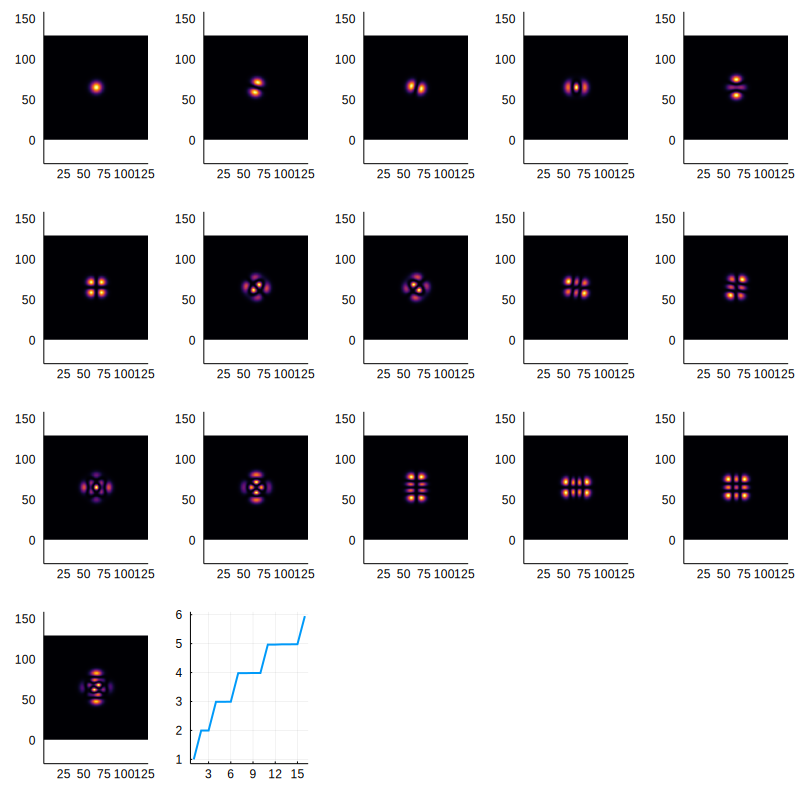

In [66]:
# Reshape and plot results
p1 = plot(val, lw=2, legend = :none)
plot_arr = Array{typeof(p1)}(undef, number_eig+1);
for i in 1:number_eig
    plot_arr[i] = heatmap( reshape( abs.(vec[:,i]).^2, grid_dim, grid_dim)[Integer(grid_dim/4):Integer(3*grid_dim/4),Integer(grid_dim/4):Integer(3*grid_dim/4)], 
                            legend = :none, aspect_ratio=:equal, 
                            grid=false, border=nothing, axiscolor=nothing)
end
plot_arr[1 + number_eig] = p1;
plot(plot_arr..., size=(800,800))